In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
ChIPSeeker_df = pd.read_csv("../07C_annotated_peaks.csv")
print(ChIPSeeker_df.shape)
ChIPSeeker_df.head()

(654221, 17)


,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
0,chr1,794225,794725,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,9829.0,NaN,LOC124903817,uncharacterized LOC124903817
1,chr1,794870,795370,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,10474.0,NaN,LOC124903817,uncharacterized LOC124903817
2,chr1,798149,798649,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,13753.0,NaN,LOC124903817,uncharacterized LOC124903817
3,chr1,802010,802510,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,817371,819837,2467,1,400728,ENST00000326734.2,-14861.0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B
4,chr1,806997,807497,501,*,"Exon (ENST00000412115.2/105378580, exon 4 of 5)",1,817371,819837,2467,1,400728,ENST00000326734.2,-9874.0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B


In [4]:
overlap_df = pd.read_csv("snATAC_peak_to_enhancer_intersection.bed", delim_whitespace=True, header = None)
overlap_df.columns = ["seqnames", "start", "end", "num_enhancer_overlap"]
overlap_df.head()
print(overlap_df.shape)

(566203, 4)


Note that this overlap_df has fewer peaks than the ChIPSeeker_df since it was already filtered to those peaks that are at least 1000 nt away from the closest TSS, using the distanceToTSS field.

#### Merge these two dfs together

In [5]:
merged_df = overlap_df.merge(ChIPSeeker_df, on = ["seqnames", "start", "end"])
merged_df.shape

(566203, 18)

In [6]:
merged_df.head()

,seqnames,start,end,num_enhancer_overlap,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
0,chr1,794225,794725,0,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,9829.0,NaN,LOC124903817,uncharacterized LOC124903817
1,chr1,794870,795370,0,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,10474.0,NaN,LOC124903817,uncharacterized LOC124903817
2,chr1,798149,798649,0,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,784396,807321,22926,1,124903817,ENST00000586288.1,13753.0,NaN,LOC124903817,uncharacterized LOC124903817
3,chr1,802010,802510,0,501,*,"Intron (ENST00000655765.1/105378580, intron 1 ...",1,817371,819837,2467,1,400728,ENST00000326734.2,-14861.0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B
4,chr1,806997,807497,0,501,*,"Exon (ENST00000412115.2/105378580, exon 4 of 5)",1,817371,819837,2467,1,400728,ENST00000326734.2,-9874.0,ENSG00000177757,FAM87B,family with sequence similarity 87 member B


In [7]:
# get the simplified annotation
merged_df['simplified_annotation'] = merged_df['annotation'].str.split('(').str[0].str.strip()

In [8]:
Counter(merged_df.simplified_annotation)

Counter({'Intron': 339489,
         'Distal Intergenic': 160973,
         'Exon': 38610,
         "3' UTR": 23542,
         "5' UTR": 2745,
         'Downstream': 844})

In [9]:
np.max(merged_df.num_enhancer_overlap)

2

In [10]:
# add binary for whether peak overlaps at least 1 Spurrell enhancer
merged_df['num_enhancer_overlap'] = np.where(merged_df['num_enhancer_overlap'] >= 1, "Y", "N")

In [11]:
Counter(merged_df['num_enhancer_overlap'])

Counter({'N': 435912, 'Y': 130291})

In [12]:
# filter to the columns: num_enhancer_overlap, simplified annotation and produce chart
filtered_df = ( merged_df[["num_enhancer_overlap", 
                           "simplified_annotation"]].groupby(["simplified_annotation", 
                                                              "num_enhancer_overlap"]).size().reset_index() )
filtered_df = filtered_df.rename(columns = {0: "num_enhancers"})
filtered_df

,simplified_annotation,num_enhancer_overlap,num_enhancers
0,3' UTR,N,18415
1,3' UTR,Y,5127
2,5' UTR,N,2205
3,5' UTR,Y,540
4,Distal Intergenic,N,131371
5,Distal Intergenic,Y,29602
6,Downstream,N,673
7,Downstream,Y,171
8,Exon,N,31214
9,Exon,Y,7396


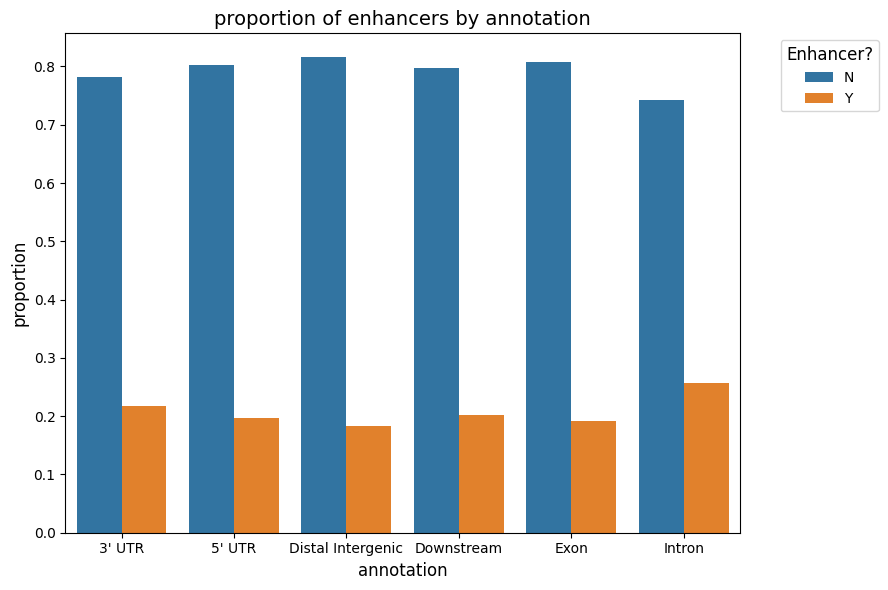

In [13]:
# add proportion
filtered_df['proportion'] = filtered_df.groupby('simplified_annotation')['num_enhancers'].transform(lambda x: x / x.sum())

plt.figure(figsize=(9, 6))
sns.barplot(
    data=filtered_df,
    x='simplified_annotation',
    y='proportion',
    hue='num_enhancer_overlap')

plt.xlabel("annotation", fontsize=12)
plt.ylabel("proportion", fontsize=12)
plt.title("proportion of enhancers by annotation", fontsize=14)
plt.legend(title="Enhancer?", fontsize=10, title_fontsize=12, bbox_to_anchor = (1.05, 1))

# Show plot
plt.tight_layout()
plt.savefig("plots/enhancer_proportion_per_ChIPSeeker_annotation.pdf")
plt.show()